In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Theory due to $p(z)$ uncertainty

In [16]:
dth = np.load("/Users/tkarim/research/galCIB/data/theory_pz_variations_20250722.npz")
dth_ns = np.load("/Users/tkarim/research/galCIB/data/theory_pz_variations_20250722_noshot.npz")

In [26]:
fname = "/Users/tkarim/research/galCIB/data"

np.save(f"{fname}/theory_pz_variations_20250722_cgg.npy",
        dth['cgg'])
np.save(f"{fname}/theory_pz_variations_20250722_cgI.npy",
        dth['cgI'])
np.save(f"{fname}/theory_pz_variations_20250722_cII.npy",
        dth['cII'])

# no shot noise
np.save(f"{fname}/theory_pz_variations_20250722_cgg_noshot.npy",
        dth_ns['cgg'])
np.save(f"{fname}/theory_pz_variations_20250722_cgI_noshot.npy",
        dth_ns['cgI'])
np.save(f"{fname}/theory_pz_variations_20250722_cII_noshot.npy",
        dth_ns['cII'])

In [23]:
ells = np.arange(3071) 
c3=['b','g','r']
c6 = ['lightblue', 'b', 
      'lightgreen','g',
      'r', 'darkred']

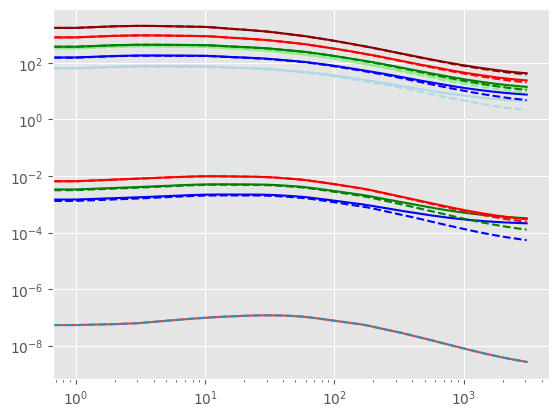

In [25]:
plt.loglog(ells, 
           dth['cgg'].mean(axis=0),
           label='gg')

plt.loglog(ells, 
           dth_ns['cgg'].mean(axis=0),
           label='gg',ls="--")

for i in range(3):
    plt.loglog(ells, 
            dth['cgI'].mean(axis=0)[i],
            label='gI',
            c=c3[i])
    
    plt.loglog(ells, 
            dth_ns['cgI'].mean(axis=0)[i],
            label='gI',ls='--',
            c=c3[i])
    
for i in range(6):
    plt.loglog(ells, 
            dth['cII'].mean(axis=0)[i],
            label='II',
            c=c6[i])
    
    plt.loglog(ells, 
            dth_ns['cII'].mean(axis=0)[i],
            label='II',
            c=c6[i],ls='--')

# Test of pipeline

## Step 1: Setup `Survey` parameters

### Galaxy properties

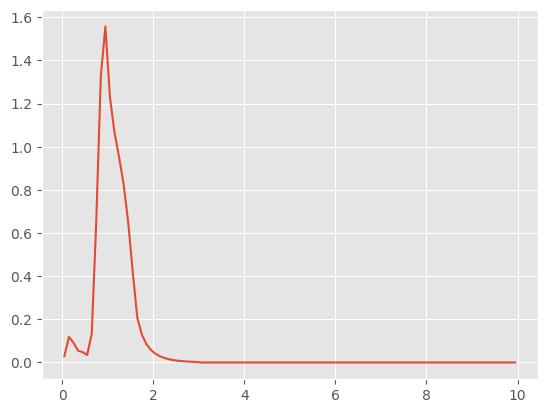

In [3]:
dndz_file=np.load("/Users/tkarim/research/galCIB/data/gal/dndz_extended.p",
        allow_pickle=True)
zs=dndz_file['zrange']
pz=dndz_file['dndz'].mean(axis=0)

zs = np.concatenate((zs,np.arange(2.85, 10.05, 0.1)[2:]))
pz = np.concatenate((pz,np.arange(2.85, 10.05, 0.1)[2:]*0))

plt.plot(zs, pz)

### CIB Properties

In [4]:
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters

cib_filters = load_my_filters("/Users/tkarim/research/galCIB/data/filters/",
                nu_obs=nu_obs)

## Step 2: Setup `Survey`

In [5]:
from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)

NSIDE = 1024 
mag_alpha = 1
# mag_alpha = 2.225
#mag_alpha = 2 #FIXME: turn on mag bias 

elg_survey = Survey(z=zs, 
                 pz=pz, mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE,
                 name="DESI-Planck")

## Step 3: Setup `Cosmology`

In [6]:
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh,
                  colossus_cosmo_name='planck18',
                  use_little_h=False)

In [7]:
# optional save hmf and bias for DopperCIB test 

# np.save("/Users/tkarim/research/galCIB/tmp/hmf.npy",
#         cosmo.hmf_grid)

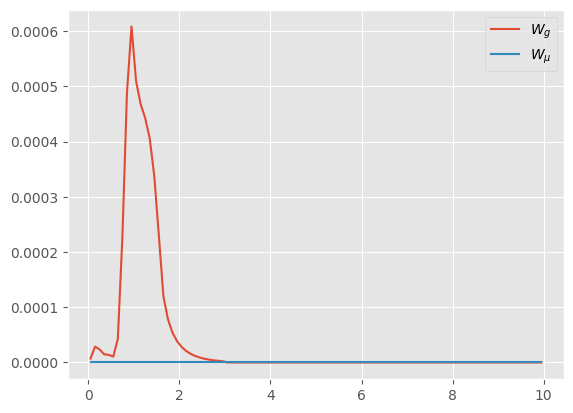

In [7]:
# Calculate window 

elg_survey.compute_windows(cosmo)
plt.plot(cosmo.z, elg_survey.Wg, label = r'$W_g$')
plt.plot(cosmo.z, elg_survey.Wmu, label = r'$W_{\mu}$')
plt.legend(loc='best')

## Step 4: Setup `HODModel` by using default model "DESI-ELG"

In [8]:
# Setup galaxy HOD

from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

## Step 5: Setup `SatProfile` 

Satellite galaxy profile in the $1$-halo term.

In [9]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

#theta_sat = np.array([0.58, 6.14, 0.67])
theta_prof = np.array([0., 6.14, 1]) # no unfw
elg_sat_profile = SatProfile(cosmo, theta_prof,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:39: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


In [92]:
# optional save hmf and bias for DopperCIB test 

# np.save("/Users/tkarim/research/galCIB/tmp/bnu.npy",
#         elg_sat_profile.hbias)

## Step 6: Setup `CIBModel` and its submodule classes

### Step 6a: Setup `SFRModel` 

Using default SFR Model "M21" and applying the `HODModel` "Zheng05" on the IR-emitting galaxies. 

In [10]:
from galCIB import SFRModel

# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR,
                     fsub=0.134)

### Step 6b: Setup `SnuModel`

Using the default parametric "Y23" and the non-parametric "M21" models. 

In [11]:
from galCIB import SnuModel, CIBModel

#### Step 6bI : Setup "Y23" 

Test this model.

In [13]:
from galCIB import SnuModel

# Parametric Snu model (Y23)
snu_model_Y23 = SnuModel(name="Y23", cosmo=cosmo,
                         survey=elg_survey)

##### Combine at the level of `CIBModel` 

Calculate djc and djsub.

In [67]:
from galCIB import CIBModel 

# Initialize CIB model
cib_Y23 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_Y23,
                   hod_IR=hod_IR,
                   survey=elg_survey,
                   cosmo=cosmo
                   )

fsub = 0.134


In [138]:
# Parameters
theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([5e-14, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [18]:
# Update cache
cib_Y23.update(theta_sfr, theta_snu, theta_IR)

# Access emissivities
djc = cib_Y23.get_djc()
djsub = cib_Y23.get_djsub()

(100, 20)
set Ncen_IR = 1 for testing.
(98, 100, 20)


In [139]:
tst = snu_model_Y23(theta_snu)
tst.shape

(3, 20)

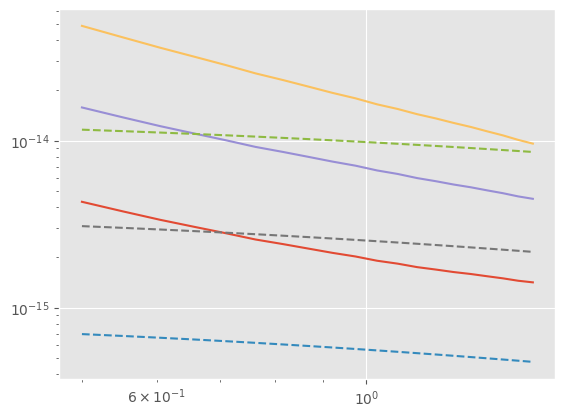

In [140]:
for i in range(3):
    plt.loglog(cosmo.z, 
             snu_model_M21(None)[i])
    
    plt.loglog(cosmo.z, 
             tst[i],ls = '--')

#### Step 6bII : Setup "M21" 

Test this model.

In [12]:
# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         survey=elg_survey,
                         nu_prime=np.array([353, 545, 857]))

In [13]:
# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR
                   )

## Step 7: Setup `PkBuilder` 

In [14]:
from galCIB import PkBuilder

In [15]:
# Y23 
# pk_survey_Y23 = PkBuilder(cosmology=cosmo,
#                       hod_model=elg_hod_model,
#                       cib_model=cib_Y23,
#                       prof_model=elg_sat_profile
#                       )

# M21 
pk_survey_M21 = PkBuilder(
                      hod_model=elg_hod_model,
                      cib_model=cib_M21,
                      prof_model=elg_sat_profile
                      )

In [16]:
# parameters

# theta_cen = {}
# theta_sat = {}
# theta_prof = {}
theta_sfr = {}
theta_snu = {}
theta_IR  = {}

theta_cen = np.array([5.29784602, 11.79855648,0.59689872,  0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.72366462,10**11.77445494, 10**13., -0.19832352]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.31701458,  5.21965594,  0.08534324]) # fexp, tau, lambda_NFW
#theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

# theta_sfr_M21 = np.array([0.63814394, # etamax
#                           13.88985729, -2.21514631, # mu0peak, muppeak
#                           1.28292033,  0.92461425, 2.38010441]) # sigmaM0, tauSFR, zc

theta_sfr_M21 = np.array([0.63814394, # etamax
                          12.73, # Mpeak
                          1.28292033,  0.92461425, 2.38010441]) # sigmaM0, tauSFR, zc

theta_snu_M21 = None 
# theta_IR_M21 = np.array([11.35534397, -1.75224461, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM
theta_IR_M21 = np.array([10.44, 0.4]) # Mmin, sigma_lnM

theta_sfr_Y23 = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.4, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu_Y23 = np.array([5e-14, 1.98,21.13, 0.21, 1.7]) # L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR_Y23 = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

theta_sfr['M21'] = theta_sfr_M21
theta_snu['M21'] = theta_snu_M21
theta_IR['M21'] = theta_IR_M21

theta_sfr['Y23'] = theta_sfr_Y23
theta_snu['Y23'] = theta_snu_Y23 
theta_IR['Y23'] = theta_IR_Y23

# theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
#                       11.78,0.40, #mu0_peak, mup_peak
#                       2.47,0.45,1.93]) #sigmaM0, tau, zc
# theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
# theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [17]:
# Pk predictions 
snu_models = ['M21']#, 'Y23']
pgg = {}
pII = {}
pgI = {}
pmuI = {}
pgmu = {}
pk_survey = {}
pk_survey['M21'] = pk_survey_M21
#pk_survey['Y23'] = pk_survey_Y23

for snu in snu_models:
    pgg, pII, pgI, pgmu, pmuI = pk_survey[snu].compute_pk(
        theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr[snu],
                     theta_snu=theta_snu[snu],
                     theta_IR_hod=theta_IR[snu],
                     hmalpha=1)

/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:73: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


#### Model the impact of magnification bias

Currently mag-bias is not properly implemented. Model this impact separately here to test how to best implement in the code. 

1.55


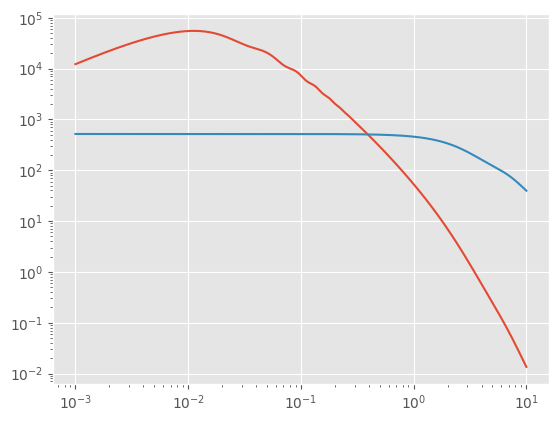

In [53]:
zidx = 15
print(zs[zidx])
plt.loglog(ks,pk_survey[snu].pk_gg_2h[:,zidx])
plt.loglog(ks,pk_survey[snu].pk_gg_1h[:,zidx])

9.950000000000006


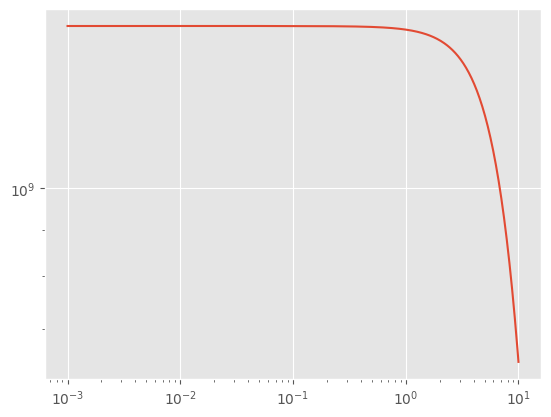

In [28]:
# zidx = 0
# print(cosmo.z[zidx])
# plt.loglog(ks, pgg['M21'][:,zidx])

zidx = -1
print(cosmo.z[zidx])
plt.loglog(ks, pgg['M21'][:,zidx])

In [171]:
def pgm_2h_simple(pkobj):
    """
    Returns the 2-halo term of P_gm, assuming bias_m = 1.
    """
    
    plin = pkobj.cosmo.pk_grid # (Nk, Nz)
    nbar = pkobj.nbar # (Nz,)
    Ig = pkobj.Ig # (Nk,Nz)
    
    p2h = plin/nbar[None,:] * Ig
    
    return p2h 

def pmm_2h_simple(pkobj):
    plin = pkobj.cosmo.pk_grid # (Nk, Nz)
    return plin 

# Assume mass profile follows NFW strictly so cache
um_prof = SatProfile(cosmo, None, profile_type='nfw').u

#from scipy.integrate import simpson
tintegrand = pk_survey['M21'].hmf * pk_survey['M21'].cosmo.Mh[:,None]
rho_m = simpson(tintegrand, dx=pk_survey['M21'].dlog10Mh, axis=0)

def pgm_2h_full(pkobj):
    plin = pkobj.cosmo.pk_grid # (Nk, Nz)
    nbar = pkobj.nbar # (Nz,)
    Ig = pkobj.Ig # (Nk,Nz)  
    hmfxbias = pkobj.hmfxbias # (NMh, Nz)
    Mh = pkobj.cosmo.Mh # (NMh,)
    
    integrand_M = hmfxbias[None,:,:] * Mh[None,:,None] * um_prof
    Im = simpson(integrand_M,dx=pk_survey['M21'].dlog10Mh,axis=1)
    
    p2h = plin/nbar[None,:] * Ig * Im/rho_m[None,:]
    
    return p2h

def pgm_1h_full(pkobj):
    hmf = pkobj.hmf # (NMh, Nz)
    Mh = pkobj.cosmo.Mh # (Mh,)
    Nc_plus_Nsat_u = pkobj.ncen_plus_nsat_u
    
    integrand = hmf[None,:,:] * Mh[None,:,None] * Nc_plus_Nsat_u * um_prof
    integral = simpson(integrand, dx=pk_survey['M21'].dlog10Mh, axis=1)
    
    p1h = integral/rho_m[None,:]
    
    return p1h

def pmumu_2h_full(pkobj):
    plin = pkobj.cosmo.pk_grid # (Nk, Nz)
    hmfxbias = pkobj.hmfxbias # (NMh, Nz)
    Mh = pkobj.cosmo.Mh # (NMh,)
    
    integrand_M = hmfxbias[None,:,:] * Mh[None,:,None] * um_prof
    Im = simpson(integrand_M,dx=pk_survey['M21'].dlog10Mh,axis=1)
    
    p2h = plin * (Im/rho_m[None,:])**2
    
    return p2h

def pmumu_1h_full(pkobj):
    hmf = pkobj.hmf # (NMh, Nz)
    Mh = pkobj.cosmo.Mh # (Mh,)
    
    integrand = hmf[None,:,:] * Mh[None,:,None] * um_prof
    integral = simpson(integrand, dx=pk_survey['M21'].dlog10Mh, axis=1)
    
    p1h = (integral/rho_m[None,:])**2
    
    return p1h

In [172]:
pgm_2h_s = pgm_2h_simple(pk_survey['M21'])
pgm_2h_f = pgm_2h_full(pk_survey['M21'])
pgm_1h_f = pgm_1h_full(pk_survey['M21'])
pmm_2h_f = pmumu_2h_full(pk_survey['M21'])
pmm_1h_f = pmumu_1h_full(pk_survey['M21'])

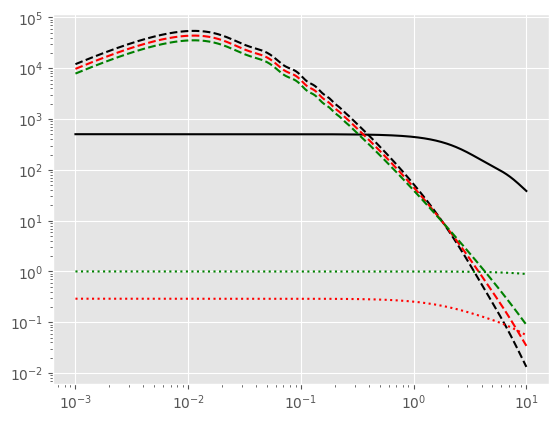

In [173]:
plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx],c='k',ls='--')
plt.loglog(ks, pk_survey['M21'].pk_gg_1h[:,zidx],c='k')

plt.loglog(ks, pgm_2h_f[:,zidx],c='r',ls='--')
plt.loglog(ks, pgm_1h_f[:,zidx],c='r',ls='dotted')

plt.loglog(ks, pmm_2h_f[:,zidx],c='g',ls='--')
plt.loglog(ks, pmm_1h_f[:,zidx],c='g',ls='dotted')

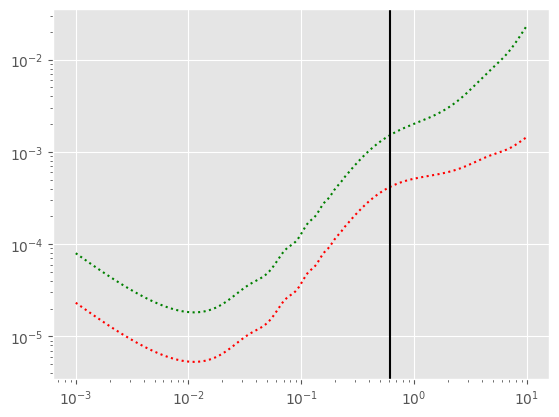

In [174]:
pgg_tot_intrinsic = pk_survey['M21'].pk_gg_1h[:,zidx] + pk_survey['M21'].pk_gg_2h[:,zidx]
# plt.loglog(ks, pgg_tot_intrinsic,c='k',ls='--')
plt.loglog(ks, pgm_1h_f[:,zidx]/pgg_tot_intrinsic,c='r',ls='dotted')
plt.loglog(ks, pmm_1h_f[:,zidx]/pgg_tot_intrinsic,c='g',ls='dotted')

plt.axvline(0.61, c = 'k')

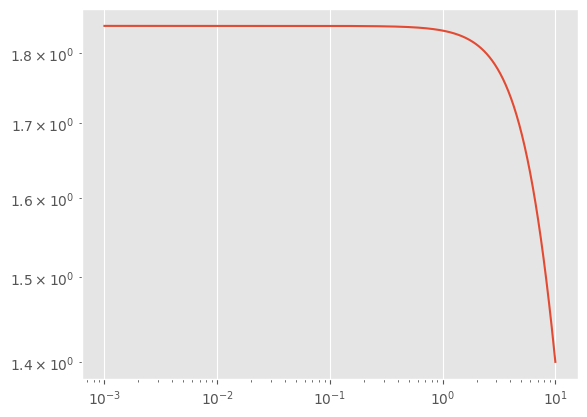

In [175]:
plt.loglog(ks, 
           (pmm_2h_f/cosmo.pk_grid)[:,zidx])

In [176]:
np.interp(0.61, ks, (pmm_2h_f/cosmo.pk_grid)[:,zidx])/(pmm_2h_f/cosmo.pk_grid)[0,zidx] - 1

-0.001429232732972463

In [177]:
(pgm_2h_f/pgm_2h_s)[0,zidx]

1.3564520461578944

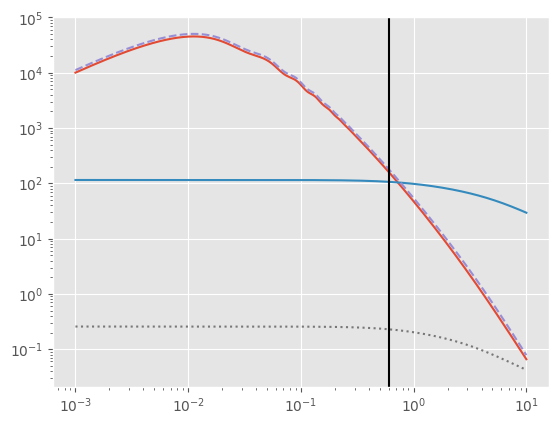

In [141]:
plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx])
plt.loglog(ks, pk_survey['M21'].pk_gg_1h[:,zidx])

plt.loglog(ks, pgm_2h_f[:,zidx],ls='--')
plt.loglog(ks, pgm_1h_f[:,zidx],ls='dotted')

plt.axvline(0.61, c = 'k')

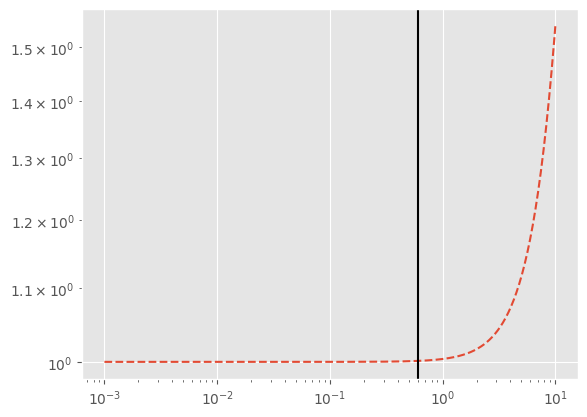

In [142]:
plt.loglog(ks, pgm_1h_f[:,zidx]/pgm_2h_f[:,zidx] + 1,ls='--')
plt.axvline(0.61, c = 'k')

In [146]:
np.interp(0.61, ks, pgm_1h_f[:,zidx]/pgm_2h_f[:,zidx] + 1)

1.00130423603143

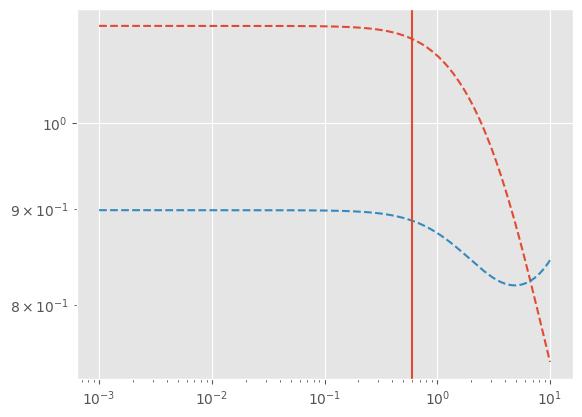

In [129]:
plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx]/pgm_2h_s[:,zidx],ls='--')
plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx]/pgm_2h_f[:,zidx],ls='--')
plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx]/pgm_2h_f[:,zidx],ls='dotted')
plt.axvline(0.6)

0.763157894736842


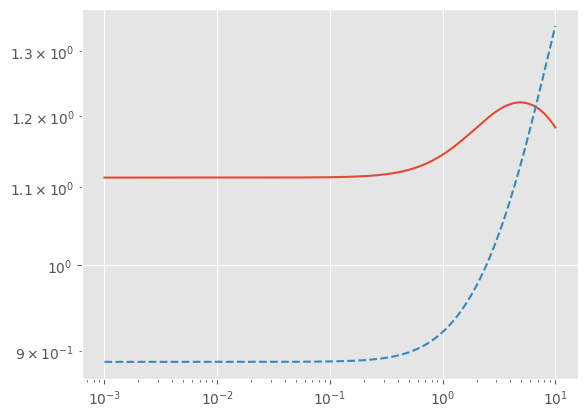

In [125]:
zidx = 5
print(cosmo.z[zidx])
# plt.loglog(ks, pk_survey['M21'].pk_gg_2h[:,zidx],c='k')
plt.loglog(ks, pgm_2h_f[:,zidx]/pk_survey['M21'].pk_gg_2h[:,zidx])
# )
plt.loglog(ks, pgm_2h_s[:,zidx]/pk_survey['M21'].pk_gg_2h[:,zidx],
           ls='--')

0.5
1.5


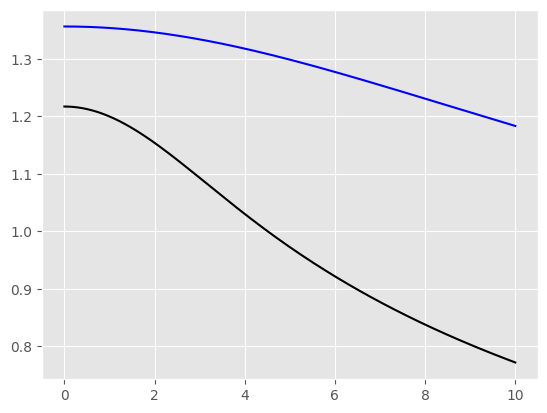

In [115]:
zidx = 0
print(cosmo.z[zidx])
plt.plot(ks, pgm_2h_f[:,zidx]/pgm_2h_s[:,zidx], c ='k')
# plt.loglog(ks, pgm_2h_f[:,zidx],ls='--', c='k')

zidx = -1
print(cosmo.z[zidx])
plt.plot(ks, pgm_2h_f[:,zidx]/pgm_2h_s[:,zidx], c = 'b')
# plt.loglog(ks, pgm_2h_f[:,zidx],ls='--', c='b')

In [82]:
import astropy.cosmology.units as cu
import astropy.units as u 
u.add_enabled_units(cu)

In [93]:
rho_m_colossus = cosmo.cosmo.rho_m(cosmo.z) * u.Msun/u.kpc**3 * cu.littleh**2
rho_m_colossus = rho_m_colossus.to(u.Msun/u.Mpc**3, cu.with_H0(planck.H0)).value
rho_m_colossus

array([1.33400692e+11, 1.47941340e+11, 1.63501981e+11, 1.80117190e+11,
       1.97821543e+11, 2.16649615e+11, 2.36635984e+11, 2.57815225e+11,
       2.80221914e+11, 3.03890627e+11, 3.28855939e+11, 3.55152428e+11,
       3.82814669e+11, 4.11877238e+11, 4.42374711e+11, 4.74341663e+11,
       5.07812672e+11, 5.42822313e+11, 5.79405162e+11, 6.17595795e+11])

In [84]:
from astropy.cosmology import Planck18 as planck 
planck.H0

<Quantity 67.66 km / (Mpc s)>

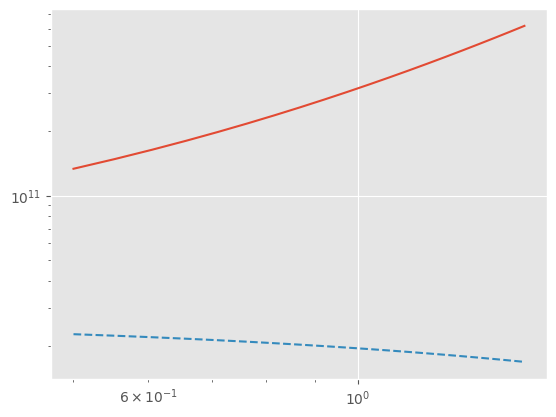

In [88]:
plt.loglog(zs, )
plt.plot(zs, rho_m, ls ='--')

In [76]:
rho_m.shape

(20,)

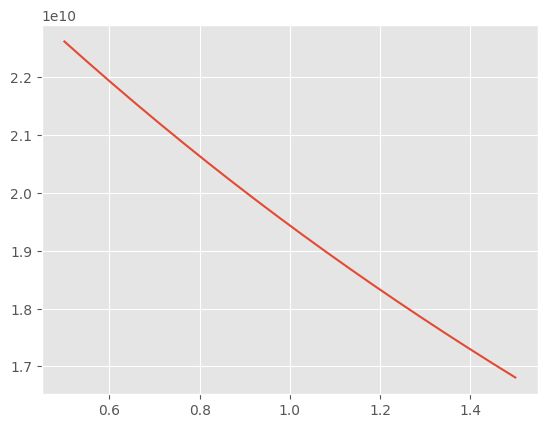

In [77]:
plt.plot(cosmo.z, rho_m)

In [78]:
rho_m

array([2.26202899e+10, 2.22561441e+10, 2.18988054e+10, 2.15483495e+10,
       2.12048051e+10, 2.08681629e+10, 2.05383849e+10, 2.02154127e+10,
       1.98991680e+10, 1.95894782e+10, 1.92861132e+10, 1.89888511e+10,
       1.86974818e+10, 1.84118085e+10, 1.81316478e+10, 1.78568303e+10,
       1.75872005e+10, 1.73226158e+10, 1.70629459e+10, 1.68080494e+10])

In [74]:
pk_survey['M21'].dlog10Mh

0.08080808080808044

In [69]:
pk_survey['M21'].hmf # (NMh, Nz)

(100, 20)

In [71]:
pk_survey['M21'].cosmo.Mh.shape # (NMh)

(100,)

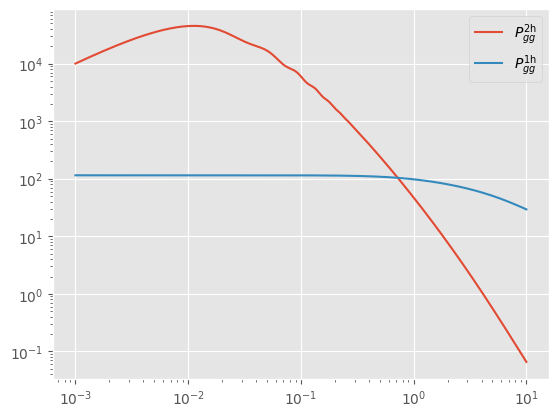

In [99]:
zidx = 5
plt.loglog(cosmo.k, 
           pk_survey['M21'].pk_gg_2h[:,zidx], 
           label = r'$P_{gg}^{\rm 2h}$')

plt.loglog(cosmo.k, 
           pk_survey['M21'].pk_gg_1h[:,zidx], 
           label = r'$P_{gg}^{\rm 1h}$')

plt.legend(loc='best')

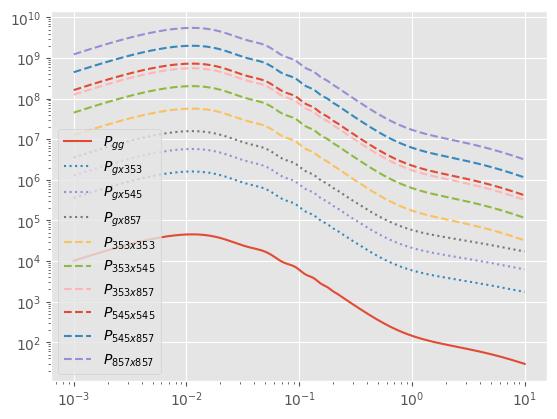

In [74]:
zidx = 5
plt.loglog(cosmo.k, pgg['M21'][:,zidx], 
           label = r'$P_{gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(cosmo.k, pgI['M21'][i,:,zidx],
               label = fr'$P_{{gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    plt.loglog(cosmo.k, pII['M21'][i,:,zidx],
               label = fr'$P_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

## Step 8: Compute $C (\ell)$ using `AnalysisModel`

In [18]:
from galCIB import AnalysisModel

In [19]:
analysis = {}

for snu in snu_models:
    analysis[snu] = AnalysisModel(
                         survey=elg_survey,
                         pk3d=pk_survey[snu])

In [20]:
cgg = {}
cgI = {}
cII = {}

for snu in snu_models:

    cgg, cgI, cII = analysis[snu].update_cl(
        theta_cen=theta_cen,
                        theta_sat=theta_sat,
                        theta_prof=theta_prof,
                        theta_sfr=theta_sfr[snu],
                        theta_snu=theta_snu[snu],
                        theta_IR_hod=theta_IR[snu],
                        theta_sn_gI=np.zeros(3),
                        theta_sn_II=np.zeros(6),
                        hmalpha=1)

In [21]:
np.savez("/Users/tkarim/research/galCIB/tmp/magbias2.225.npz",
         cgg=cgg, cgI=cgI, cII=cII)

In [21]:
mbdat = np.load("/Users/tkarim/research/galCIB/tmp/magbias2.225.npz")

In [22]:
cgg.shape

(1900,)

In [23]:
mbdat['cgg'].shape

(1900,)

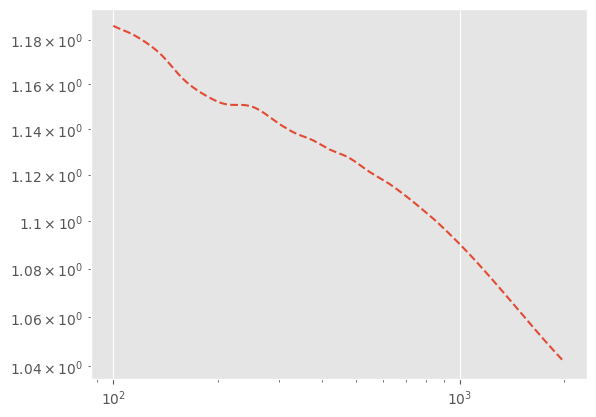

In [26]:
plt.loglog(elg_survey.ells, mbdat['cgg']/cgg, ls = '--')

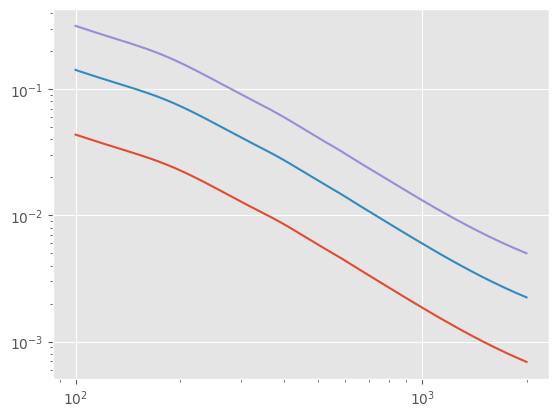

In [21]:
for i in range(3):
    plt.loglog(elg_survey.ells, cgI[i])

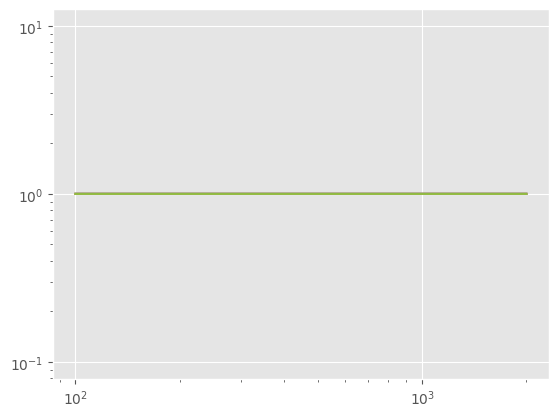

In [32]:
for i in range(6):
    plt.loglog(elg_survey.ells, mbdat['cII'][i]/cII[i])

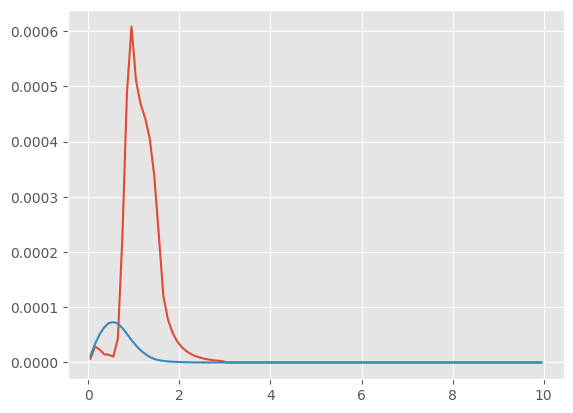

In [111]:
plt.plot(zs, analysis[snu].Wg)
plt.plot(zs, analysis[snu].Wmu)

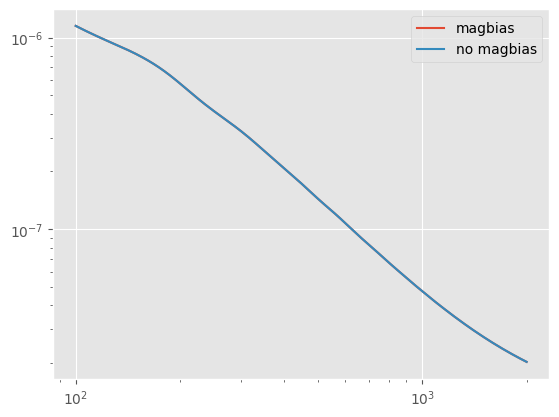

In [104]:
#galaxy

for snu in snu_models:
    plt.loglog(elg_survey.ells, 
           cgg[snu], label = 'magbias')
    plt.loglog(elg_survey.ells, 
           cggnm[snu], label = 'no magbias')
    
plt.legend(loc='best')

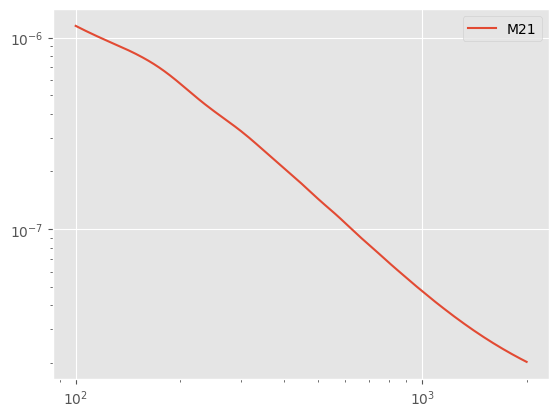

In [60]:
#galaxy

for snu in snu_models:
    plt.loglog(elg_survey.ells, 
           cgg[snu], label = snu)
    
plt.legend(loc='best')

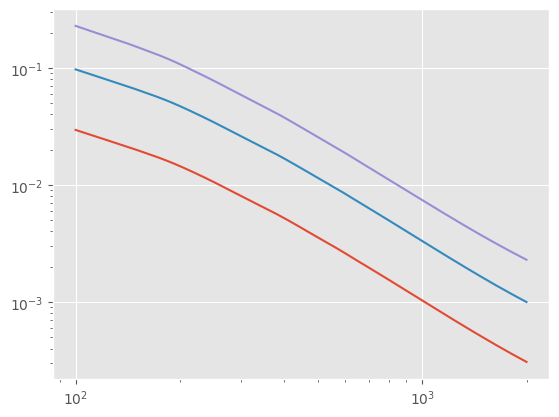

In [61]:
#gI

nulist = ['353', '545', '857']

for snu in snu_models:
    if snu == 'Y23':
        ls = 'dashed'
    else:
        ls = 'solid'
    for i in range(3):
        plt.loglog(elg_survey.ells, 
            cgI[snu][i,:],
            ls=ls)

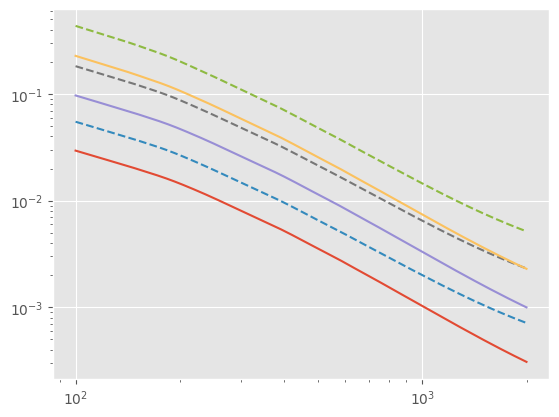

In [106]:
#gI

nulist = ['353', '545', '857']

for snu in snu_models:
    if snu == 'Y23':
        ls = 'dashed'
    else:
        ls = 'solid'
    for i in range(3):
        plt.loglog(elg_survey.ells, 
            cgI[snu][i,:],
            ls=ls)
        
        plt.loglog(elg_survey.ells, 
            cgInm[snu][i,:],
            ls='--')

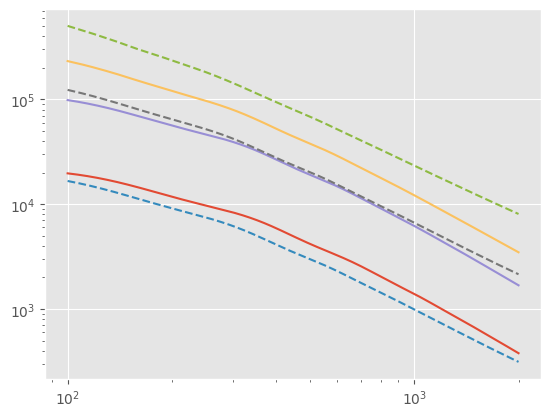

In [82]:
#II-auto

nulist = ['353', '545', '857']

for snu in snu_models:
    if snu == 'Y23':
        ls = 'dashed'
    else:
        ls = 'solid'
    
    for i in range(6):
        a,b = pk_survey[snu].twoh_pairs[i]
        
        if a == b:
            plt.loglog(elg_survey.ells, 
                    cII[snu][i,:],
                    ls = ls)
            
            plt.loglog(elg_survey.ells, 
                    cIInm[snu][i,:],
                    ls = '--')

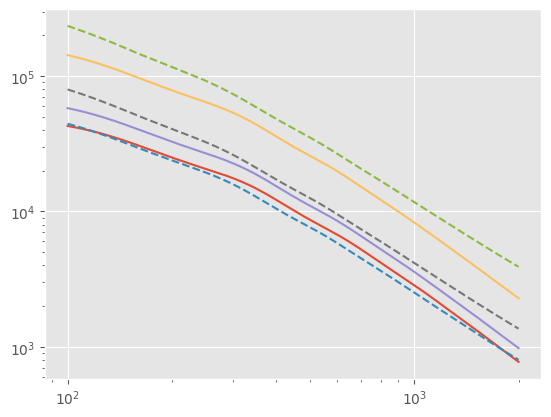

In [83]:
#II-cross

nulist = ['353', '545', '857']

for snu in snu_models:
    if snu == 'Y23':
        ls = 'dashed'
    else:
        ls = 'solid'
    
    for i in range(6):
        a,b = pk_survey[snu].twoh_pairs[i]
        
        if a != b:
            plt.loglog(elg_survey.ells, 
                    cII[snu][i,:],
                    ls = ls)
            
            plt.loglog(elg_survey.ells, 
                    cIInm[snu][i,:],
                    ls = '--')

In [41]:
tmp_cov = (cgg['M21']*cII['M21'][0] + cgI['M21'][0]**2)

In [43]:
tmp_cov = tmp_cov/(2 * np.arange(1900) + 1)

In [45]:
tmp_cob = np.diag(tmp_cov)

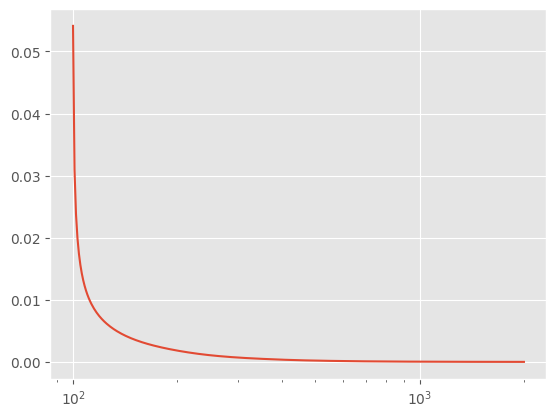

In [50]:
plt.semilogx(np.arange(100,2000), np.sqrt(tmp_cov))

<ErrorbarContainer object of 3 artists>

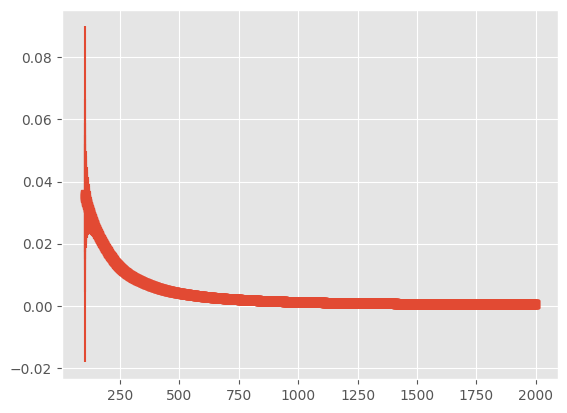

In [54]:
plt.errorbar(np.arange(100,2000), cgI['M21'][0],
             yerr=np.sqrt(tmp_cov),marker="s")

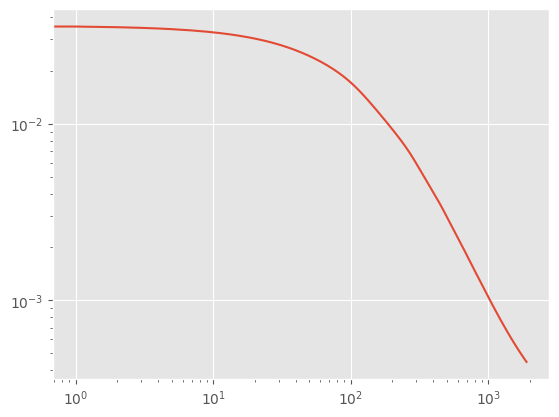

In [55]:
plt.loglog(cgI['M21'][0])

TypeError: unhashable type: 'dict'

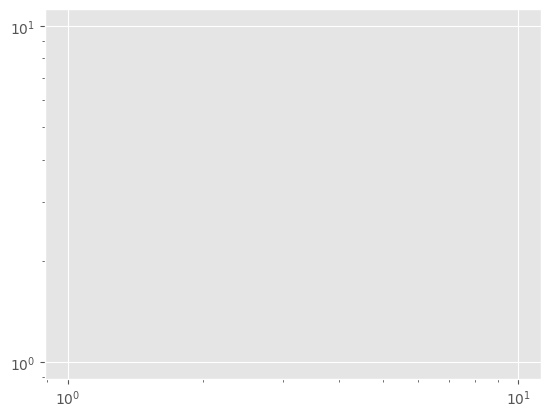

In [79]:


plt.loglog(elg_survey.ells, 
           cgg[], label = r'$C_{\rm gg}$')

# nulist = ['353', '545', '857']

# for i in range(3):
#     plt.loglog(elg_survey.ells, cgI[i,:],
#                label = fr'$C_{{\rm gx{nulist[i]}}}$',
#                ls = 'dotted')
    
# for i in range(6):
#     a,b = pk_survey['M21'].twoh_pairs[i]
#     plt.loglog(elg_survey.ells, cII[i,:],
#                label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
#                ls = 'dashed')

# plt.legend(loc='best')

##### Now try with `Y23`

# Compare with `DopplerCIB`

In [10]:
import sys 
sys.path.append("//Users/tkarim/research/DopplerCIB/")

import CIB_halo as mcib
import cosmo_related as mcosmo
import input_var_cibmean as minput
import Gal_halo as mgh
import CIBxGal_halo as mcg
import hmf_unfw_bias as mhmf_unfw

In [11]:
## initialize cosmo_var_iv and data_var_iv to pass to DopplerCIB

cosmo_var = mcosmo.cosmo_var_iv(mass=cosmo.Mh,
                                z=cosmo.z,
                                do_powerspec=1)

# experimental specification 

cib_exp = 'Planck'
# color corrections for 100, 143, 217, 353, 545, 857 and 3000 GHz for Planck
cc_pl = np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995])  # , 0.960])
cc = cc_pl  

nu0 = np.array([100., 143., 217., 353., 545., 857.]) 
nus = ['100', '143', '217', '353', '545', '857']
# fwhm obtained from https://wiki.cosmos.esa.int/planckpla/index.php/Effective_Beams
fwhm = np.array([9.651, 7.248, 4.990, 4.818, 4.682, 4.325])  # in arcmin
fwhm_rad = fwhm*(np.pi/180.)/60.
# fwhm = 4.8  # 4.8 Planck arcmin # 0.5 CCAT-Prime
# 1303.5067 for sensitivity (Tab:4 muK deg & kJy/sr deg)
sensitivity_muKarcmin = np.array([108., 48., 60., 210., 1137., 29075.])
sensitivity_Jy2_sr = np.array([58., 26.929, 72., 305, 369., 369.])
sensitivity_Jy_sr = np.sqrt(sensitivity_Jy2_sr)
# sensitivity = 13.5  # 13.5 Planck Jy/sr  # 1.2 CCAT-Prime
ell = np.logspace(2, np.log10(2000), 99)
fc = np.ones(len(nu0))

strfig = "allcomponents_lognormal_sigevol_1p5zcutoff_nolens_onlyautoshotpar_no3000_gaussian600n857n1200_planck_spire_hmflog10.txt"
cibres = "/Users/tkarim/research/galCIB/data/one_halo_bestfit_"+strfig

exp = {'name': cib_exp,
          'do_cibmean': 0,
          'cc': cc,
          'fc': fc,
          'snuaddr': '/Users/tkarim/research/galCIB/data/filtered_snu_planck.fits',
          # 'nu0min': nu0min, 'nu0max': nu0max,
          # 'nucen': str(int(nucen)),
          'nu0': nu0,
          'ell': ell,
          'fwhm': fwhm,
          'sensitivity': sensitivity_Jy_sr,
          'cibpar_resfile': cibres,
          'nu_string': nus}



Calculating the halo mass function for given mass and redshift for CIB mean calculations.


In [12]:
## initialize data_var_iv 
data_var_iv = minput.data_var_iv(exp = exp)

In [13]:
# initialize mcib_obj

mcib_obj = mcib.Cib_halo(data_var_iv,
                         cosmo_var)

In [14]:
from galCIB import SnuModel, SFRModel, CIBModel

In [17]:
theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR,
                     fsub=0.134)

# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         survey=elg_survey,
                         nu_prime=np.array([353, 545, 857]))

# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR,
                   Nm_sub=298)

In [18]:
cib_M21.update(theta_sfr=theta_sfr_M21,
               theta_snu=None,
               theta_hod_IR=theta_IR)

In [19]:
# Comparison of Snu
(cib_M21._snu[2]/mcib_obj.snu[5]).sum()/len(cosmo.z)

0.999872620893273

In [20]:
# Comparison of SFR
(sfr_model(theta_sfr_M21)/mcib_obj.sfr(cosmo.Mh*(1-0.134))).sum()/mcib_obj.sfr(cosmo.Mh).size

0.9977481105758318

In [21]:
# Comparison of djc
(mcib_obj.djc_dlnMh()[3:]/cib_M21.get_djc()).sum()/cib_M21.get_djc().size

0.134


/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_62282/510363697.py:2: RuntimeWarning: divide by zero encountered in divide
  (mcib_obj.djc_dlnMh()[3:]/cib_M21.get_djc()).sum()/cib_M21.get_djc().size


inf

In [22]:
# Comparison of djsub
(mcib_obj.djsub_dlnMh()[3:]/cib_M21.get_djsub()).sum()/cib_M21.get_djsub().size

fsub = 0.134


1.0014813749919613

In [25]:
from galCIB import PkBuilder

# M21 
pk_survey_M21 = PkBuilder(
                      hod_model=elg_hod_model,
                      cib_model=cib_M21,
                      prof_model=elg_sat_profile
                      )

# compute pk

theta_cen = np.array([3.28, 11.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.38, 10**11.14, 10**13., 0.59]) # As, M0, M1, alpha_sat
#theta_prof = np.array([0.52, 9.07, 0.7]) # fexp, tau, lambda_NFW
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM


shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = 10**(shotnoise_gCIB - 2) # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.array([225, 543, 913, 1454, 2655, 5628])

In [26]:
# Pk predictions 
snu_models = ['M21']
pgg = {}
pII = {}
pgI = {}
pk_survey = {}
pk_survey['M21'] = pk_survey_M21

for snu in snu_models:
    print(snu)
    pgg[snu], pII[snu], pgI[snu] = pk_survey[snu].compute_pk(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=1)

M21


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


In [27]:
from galCIB import AnalysisModel

analysis = AnalysisModel(
                         survey=elg_survey,
                         pk3d=pk_survey['M21'],
                         bin_cl=True)


In [25]:
bcenter, cgg_b, cgI_b, cII_b = analysis.update_cl(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     theta_sn_gI=shotnoise_gCIB,
                     theta_sn_II=shotnoise_CIBCIB,
                     hmalpha=1,bin_cl=True)

In [28]:
cgg, cgI, cII = analysis.update_cl(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     theta_sn_gI=shotnoise_gCIB,
                     theta_sn_II=shotnoise_CIBCIB,
                     hmalpha=1,bin_cl=False)

NameError: name 'bcenter' is not defined

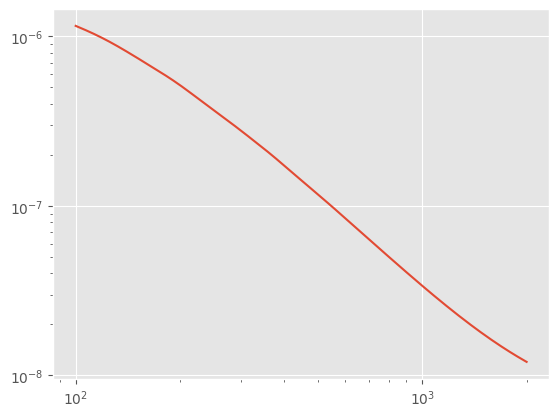

In [29]:
plt.loglog(elg_survey.ells, 
           cgg, label = r'$C_{\rm gg}$')

plt.scatter(bcenter, cgg_b)

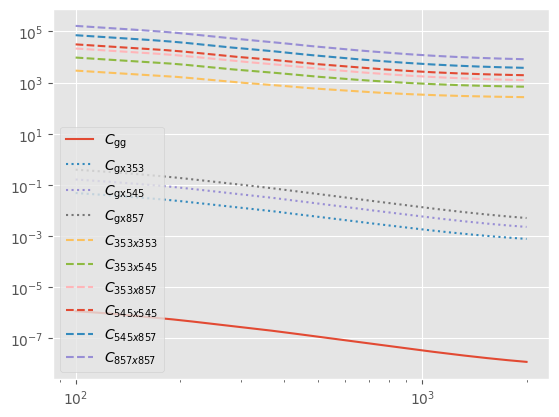

In [28]:
plt.loglog(elg_survey.ells, 
           cgg, label = r'$C_{\rm gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(elg_survey.ells, cgI[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    plt.loglog(elg_survey.ells, cII[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

In [30]:
cl_m21 = mcib_obj.twohalo_int() + mcib_obj.onehalo_int()

0.134
fsub = 0.134
0.134
fsub = 0.134


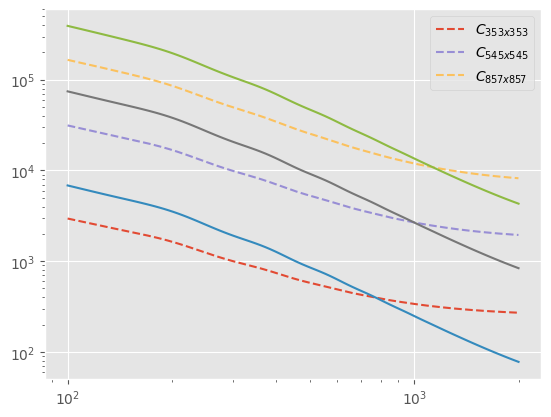

In [31]:
nulist = ['353', '545', '857']
for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    
    if a != b:
        continue
    #col_corr = mcib_obj.cc[a+3]*mcib_obj.cc[b+3]
    plt.loglog(elg_survey.ells, cII[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')
    
    plt.loglog(mcib_obj.ell, 
           cl_m21[a+3,b+3])

plt.legend(loc='best')

Test $C_{gg}$

In [32]:
mgal_obj = mgh.ProfHODMore15(data_var_iv, cosmo_var,"DESI_ELG")

In [33]:
cgg_2h_m21 = mgal_obj.cl2h_gal()
cgg_m21 = mgal_obj.cl_galtot()

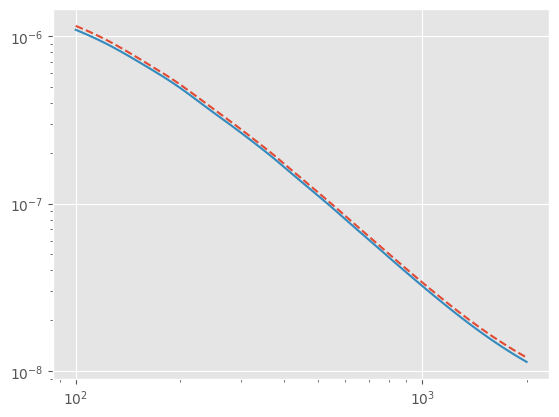

In [34]:
plt.loglog(elg_survey.ells, 
           cgg, ls = '--')

plt.loglog(mgal_obj.ell, 
           cgg_m21)

In [35]:
cgg_k_int = np.interp(mgal_obj.ell,
                      elg_survey.ells,
                      cgg)

##### Investigate why there is an amplitude offset in $C_{\rm gg}$.

In [90]:
unfw = mgal_obj.unfw 
ucen = np.ones_like(unfw)
power = mgal_obj.uni.Pk_array(mgal_obj.ell, 
                              mgal_obj.z)

For sanity, double check unfw and power again. 

In [91]:
karray = mgal_obj.uni.karray(mgal_obj.ell,
                    mgal_obj.z) # Nell, Nz

# describes the effective k-grid per-z 

In [92]:
# interpolate galCIB grid to DopplerCIB grid 

u_k_int = np.zeros_like(np.swapaxes(unfw,0,1))

for zidx in range(20):
    for midx in range(100):

        u_k_int[:,midx,zidx] = np.interp(karray[:,zidx],
                            ks, 
                            elg_sat_profile.u[:,midx,zidx])

In [93]:
(u_k_int/np.swapaxes(unfw,0,1)).sum()/u_k_int.size

1.0000000117338093

Therefore, unfw matches exceedingly well. 

In [94]:
# interpolate galCIB grid to DopplerCIB grid 

power_k_int = np.zeros_like(power)

for zidx in range(20):
    power_k_int[:,zidx] = np.interp(karray[:,zidx],
                        ks, 
                        cosmo.pk_grid[:,zidx])

In [95]:
(power_k_int/power).sum()/power.size

0.9975546064587537

Therefore, `power` also matches well.

Now check `p2h_gal`

In [96]:
pgg_2h_m21 = mgal_obj.p2h_gal(ucen, unfw, power)

In [97]:
pgg_2h_m21.shape

(99, 20)

In [98]:
# interpolate on the same grid 

# interpolate galCIB grid to DopplerCIB grid 

pgg2h_k_int = np.zeros_like(pgg_2h_m21)

for zidx in range(20):
    pgg2h_k_int[:,zidx] = np.interp(karray[:,zidx],
                        ks, 
                        pk_survey['M21'].pk_gg_2h[:,zidx])

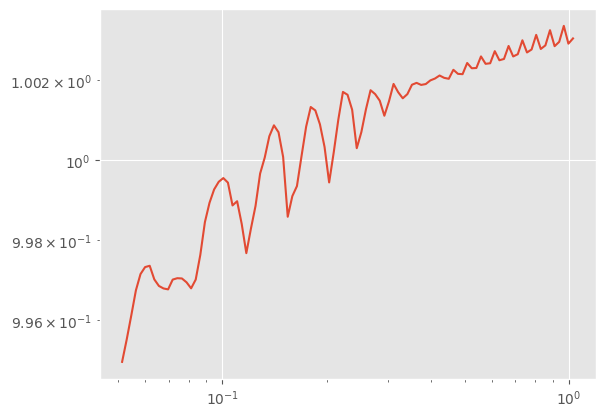

In [121]:
zidx = 0
plt.loglog(karray[:,zidx],
           pgg2h_k_int[:,zidx]/pgg_2h_m21[:,zidx])


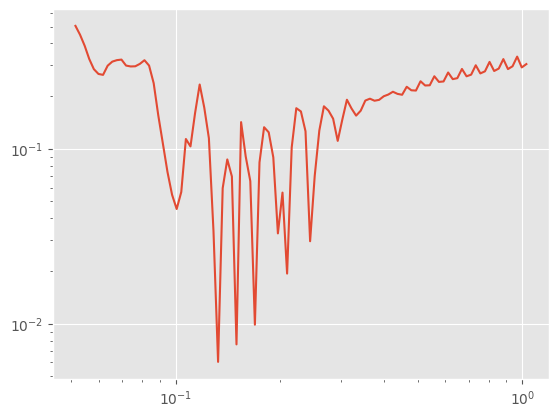

In [122]:
metric = np.abs(pgg2h_k_int[:,zidx]/pgg_2h_m21[:,zidx] - 1)*100

plt.loglog(karray[:,zidx], metric)

So the 2-halo term looks difference as a function of scale. Need to find out why. 

In [104]:
(mgal_obj.biasmz/elg_sat_profile.hbias).sum()/elg_sat_profile.hbias.size

1.0

In [105]:
(mgal_obj.hmfmz/cosmo.hmf_grid).sum()/mgal_obj.hmfmz.size

1.0

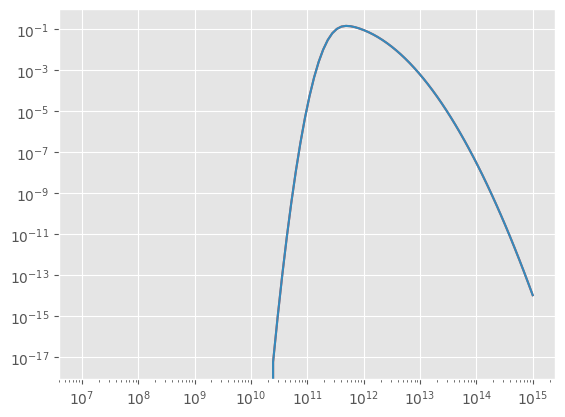

In [106]:
plt.loglog(mgal_obj.mh,
           mgal_obj.Ncen(mgal_obj.mh))

plt.loglog(cosmo.Mh,
           pk_survey['M21'].ncen[:,0])

In [108]:
nsat_m21 = np.array([mgal_obj.Nsat(m) for m in mgal_obj.mh])

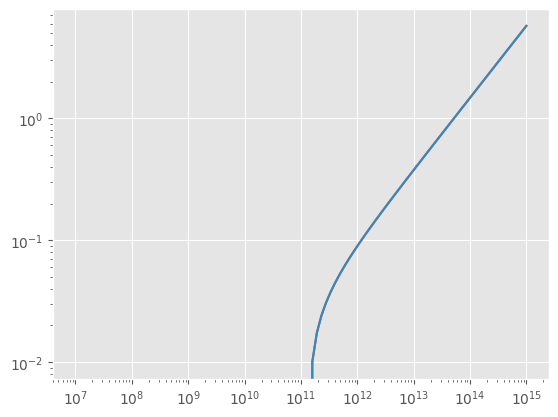

In [109]:
plt.loglog(mgal_obj.mh,
           nsat_m21)

plt.loglog(cosmo.Mh,
           pk_survey['M21'].nsat[:,0])

In [150]:
from scipy.integrate import simpson 

def cl2h_gal(mg):
    z = mg.z
    
    unfw = mg.unfw
    ucen = np.ones_like(mg.unfw) #FIXME: for test
    power = mg.uni.Pk_array(mg.ell, mg.z)
    #dchidz = mg.uni.dchi_dz(mg.z)
    dchidz = cosmo.dchi_dz
    #chi = mg.uni.chi(mg.z)
    chi = cosmo.chi

    window = mg.dn_dz()
    wind_gal = window(z)/dchidz
    geo = dchidz*wind_gal**2/chi**2
    twoh = mg.p2h_gal(ucen, unfw, power)
    integral = geo*twoh
    res = simpson(integral, x=z, axis=-1)
    return res

def cl1h_gal(mg):
    z = mg.z
    #ucen = mg.unfw
    unfw = mg.unfw
    ucen = np.ones_like(mg.unfw) #FIXME: for test
    dchidz = cosmo.dchi_dz
    chi = cosmo.chi

    window = mg.dn_dz()
    wind_gal = window(z)/dchidz
    geo = dchidz*wind_gal**2/chi**2
    oneh = mg.p1h_gal(ucen, unfw)
    # print ("one halo gal Pk %s" % (oneh[-1, -10:]))
    integral = geo*oneh
    res = simpson(integral, x=z, axis=-1)
    # print ("one halo gal cl %s" % (res[-10:]))
    return res

In [151]:
cl2h_tst_m21 = cl2h_gal(mgal_obj)
cl1h_tst_m21 = cl1h_gal(mgal_obj)
cl_tot_tst_m21 = cl2h_tst_m21 + cl1h_tst_m21

Text(0.5, 1.0, 'Fractional Percentage Difference')

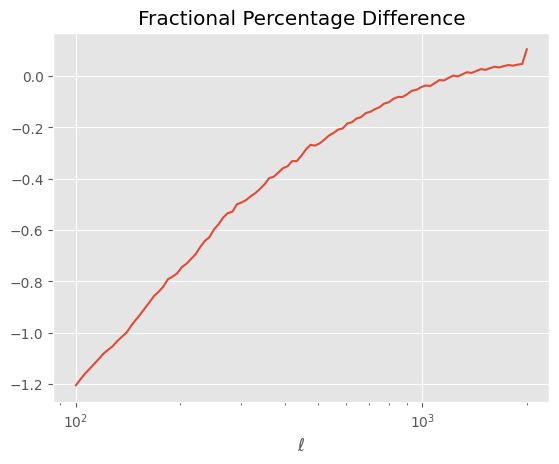

In [156]:
plt.semilogx(mgal_obj.ell,
           (cgg_k_int/cl_tot_tst_m21-1)*100)
plt.xlabel(r"$\ell$")
plt.title("Fractional Percentage Difference")

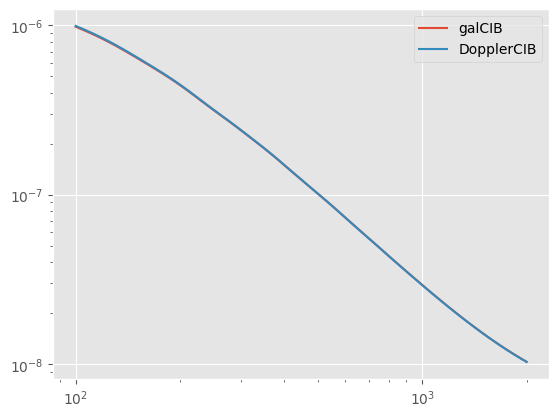

In [158]:
plt.loglog(mgal_obj.ell,
           cgg_k_int,label='galCIB')
plt.loglog(mgal_obj.ell,
             cl_tot_tst_m21,label='DopplerCIB')
plt.legend(loc='best')

In [133]:
(mgal_obj.window_gal()(mgal_obj.z))/(elg_survey.Wg*cosmo.dchi_dz)

array([1.04939496, 1.04939496, 1.04939496, 1.04939496, 1.04939496,
       1.04939496, 1.04939496, 1.04939496, 1.04939496, 1.04939496,
       1.04939496, 1.04939496, 1.04939496, 1.04939496, 1.04939496,
       1.04939496, 1.04939496, 1.04939496, 1.04939496, 1.04939496])

In [142]:
(elg_survey.Wg * cosmo.dchi_dz).sum()/mgal_obj.dn_dz()(mgal_obj.z).sum()

1.0

In [135]:
(mgal_obj.window_gal()(mgal_obj.z)).sum()

19.938504152445606

In [140]:
mgal_obj.dn_dz()(mgal_obj.z).sum() * 0.05263158

1.000000020000001

In [137]:
mgal_obj.Nbargal()(mgal_obj.z)

0.9529300620914197

In [144]:
simpson(mgal_obj.dn_dz()(mgal_obj.z),x=cosmo.z)

0.9529300620914197

In [37]:
cgg_int = np.interp(mgal_obj.ell,
                    elg_survey.ells,
                    cgg)

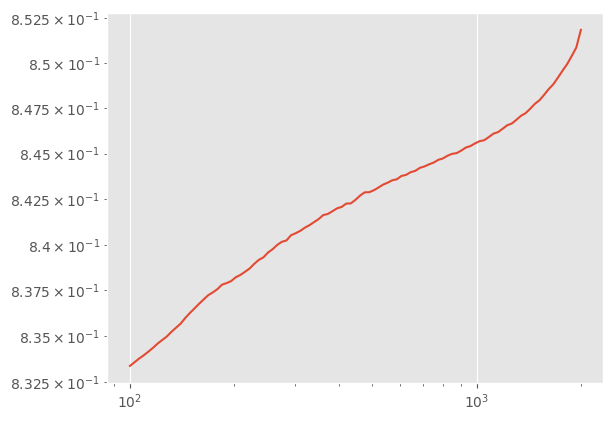

In [38]:
plt.loglog(mgal_obj.ell, 
           cgg_int/cgg_m21)

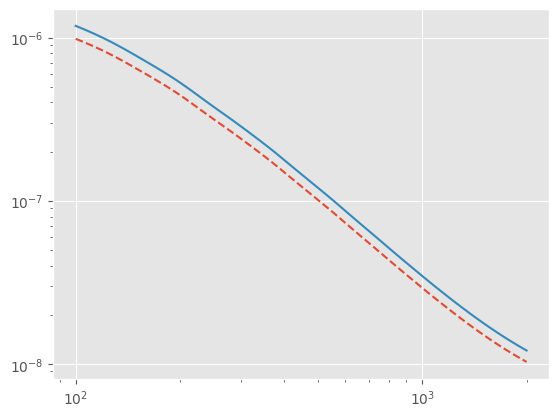

In [40]:
plt.loglog(mgal_obj.ell, 
           cgg_int,ls='--')

plt.loglog(mgal_obj.ell, 
           cgg_m21)


Test $C_{gI}$

In [42]:
mgI_obj = mcg.CIBxgal(data_var_iv,cosmo_var,
    "DESI_ELG",1)

In [45]:
mgI_obj.biasmz.shape

(100, 20)

In [50]:
cgI_m21 = mgI_obj.cibgalcross_cell_tot()[3:]

0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134
0.134
fsub = 0.134


In [51]:
cgI_m21.shape

(3, 99)

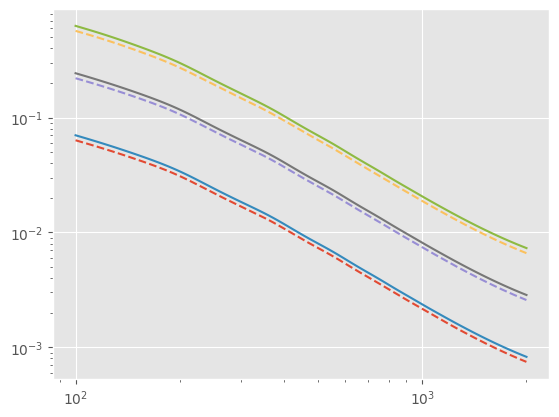

In [58]:
nidx = 0

for nidx in range(3):
    plt.loglog(elg_survey.ells,
            cgI[nidx],ls='--')
    plt.loglog(mgI_obj.ell, cgI_m21[nidx])

All combined

In [34]:
colors = ['blue', 'green', 'red']
# 353, 545, 857

# Get colormap
cmap = plt.get_cmap('winter')

# Choose values: 0.25 is bluish, 0.75 is greenish
bluish = cmap(0.25)
greenish = cmap(0.75)

cmap = plt.get_cmap('RdYlGn')
mid_color = cmap(0.5)  # This is a yellowish tone

# 353x545,353x857
colors_cross_II = [bluish,greenish,'brown']

Text(0.5, 0.98, 'Theory Predictions')

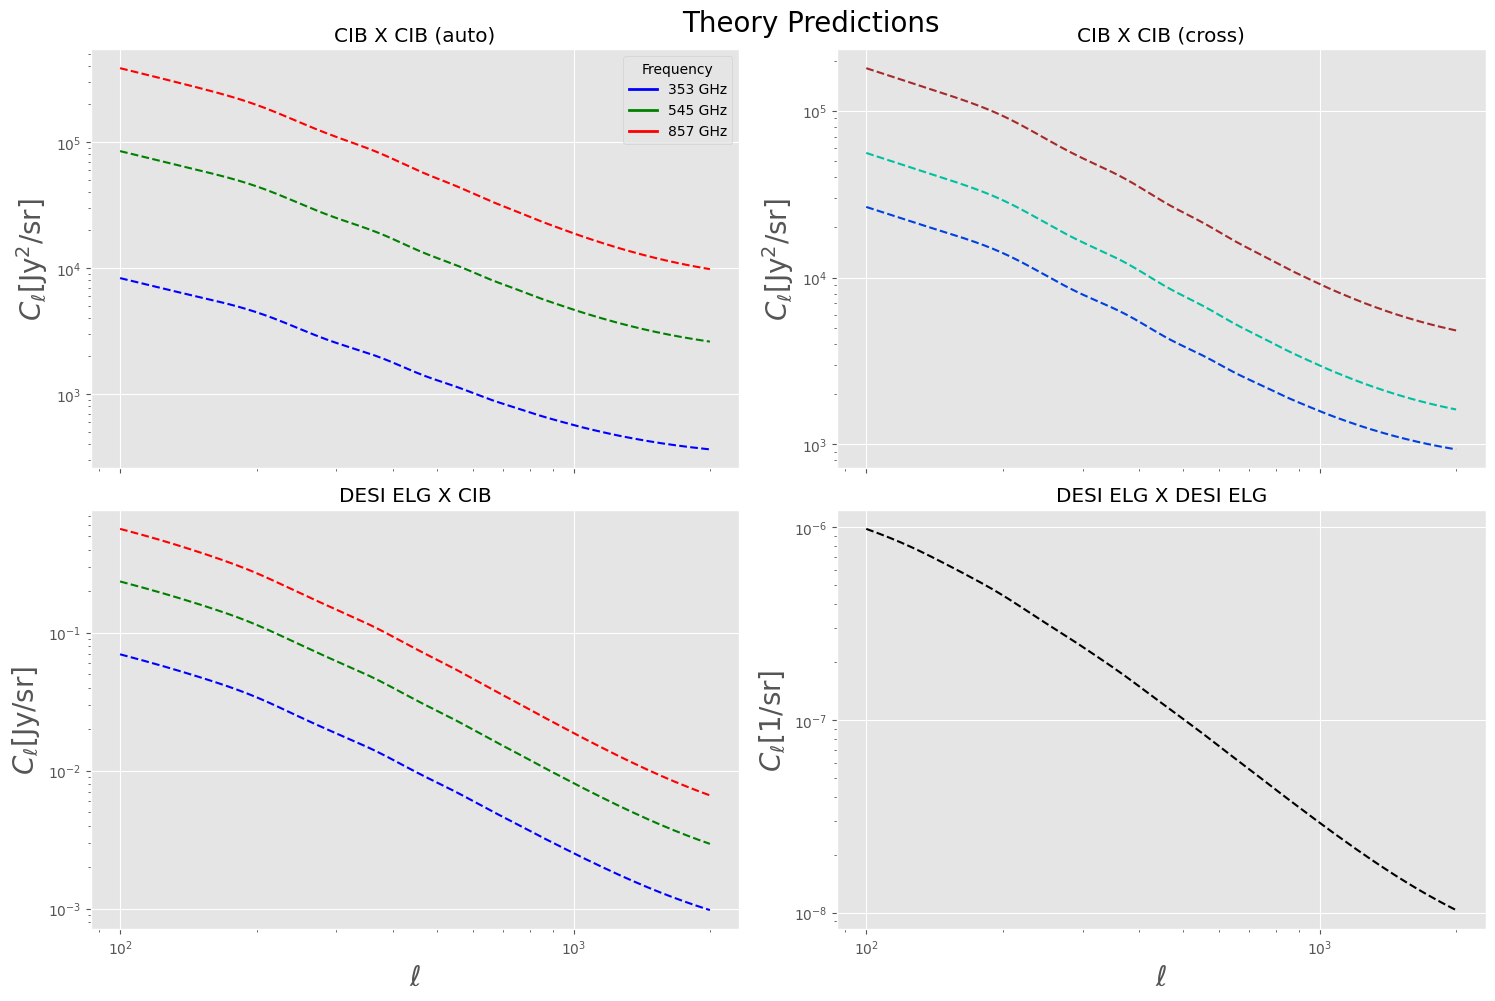

In [46]:
fig, axs = plt.subplots(2, 2, 
                        figsize=(15, 10),
                        sharex=True)

for nidx in range(3):
    axs[1,0].loglog(elg_survey.ells,
            cgI[nidx],ls='--',
            c=colors[nidx])
    # axs[1,1].loglog(mgI_obj.ell, 
    #                 cgI_m21[nidx],
    #                 c=colors[nidx])
    
axs[1,1].loglog(elg_survey.ells,
                cgg,ls='--',
                c='k')
# axs[1,0].loglog(mgal_obj.ell,
#                 cgg_m21,
#                 c='k')

for i in range(6):
    a,b = pk_survey['M21'].twoh_pairs[i]
    
    col_corr = mcib_obj.cc[a+3]*mcib_obj.cc[b+3]
    
    if a == b:
        axs[0,0].loglog(elg_survey.ells, 
                col_corr*cII[i,:],
                #label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
                ls = 'dashed',
                c=colors[a])
    
        # axs[0,0].loglog(mcib_obj.ell, 
        #         cl_m21[a+3,b+3],
        #         c=colors[a])
    else:
        axs[0,1].loglog(elg_survey.ells, 
        col_corr*cII[i,:],
        #label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$',
        ls = 'dashed',
        c=colors_cross_II[a+b-1])
        
        # axs[0,1].loglog(mcib_obj.ell, 
        # cl_m21[a+3,b+3],
        # c=colors_cross_II[a+b-1])
        
axs[0,0].set_title("CIB X CIB (auto)")
axs[0,1].set_title("CIB X CIB (cross)")
axs[1,1].set_title("DESI ELG X DESI ELG")
axs[1,0].set_title("DESI ELG X CIB")


from matplotlib.lines import Line2D
# Legend 1: Line style = model
# model_legend = [
#     Line2D([0], [0], color='black', linestyle='-', label='galCIB'),
#     Line2D([0], [0], color='black', linestyle='--', label='DopplerCIB')
# ]

# Legend 2: Color = frequency
freq_legend = [
    Line2D([0], [0], color='blue', lw=2, label='353 GHz'),
    Line2D([0], [0], color='green', lw=2, label='545 GHz'),
    Line2D([0], [0], color='red', lw=2, label='857 GHz')
]

# --------------- Add the legends anywhere ---------------

# Example: Add model legend to upper left subplot (axs[0,0])
# axs[1,0].legend(handles=model_legend, title='Model', loc='upper right')

# Example: Add frequency legend to lower right subplot (axs[1,1])
axs[0,0].legend(handles=freq_legend, title='Frequency', loc='upper right')

plt.tight_layout()

fig.subplots_adjust(left=0.02, bottom=0.06, 
                    right=0.95, top=0.94, 
                    wspace=0.15)

# labels
fs = 20
axs[1,0].set_xlabel(r"$\ell$", fontsize = fs)
axs[1,1].set_xlabel(r"$\ell$", fontsize = fs)
axs[0,0].set_ylabel(r"$C_{\ell} [\rm{Jy^{2}/sr}]$",
                    fontsize=fs)
axs[0,1].set_ylabel(r"$C_{\ell} [\rm{Jy^{2}/sr}]$",
                    fontsize=fs)
axs[1,0].set_ylabel(r"$C_{\ell} [\rm{Jy/sr}]$",
                    fontsize=fs)
axs[1,1].set_ylabel(r"$C_{\ell} [\rm{1/sr}]$",
                    fontsize=fs)
# plt.savefig("../figures/compare-dopplercib-galcib.pdf",
#             bbox_inches='tight', dpi=300)

plt.suptitle("Theory Predictions",fontsize=fs)

# Theory curves with $p(z)$ uncertainty

In [34]:
theory = np.load("/Users/tkarim/research/galCIB/data/theory_pz_variations_20250721.npz")

In [37]:
cgI_r = theory['cgI'].reshape(1000,3,3071)
cII_r = theory['cII'].reshape(1000,6,3071)

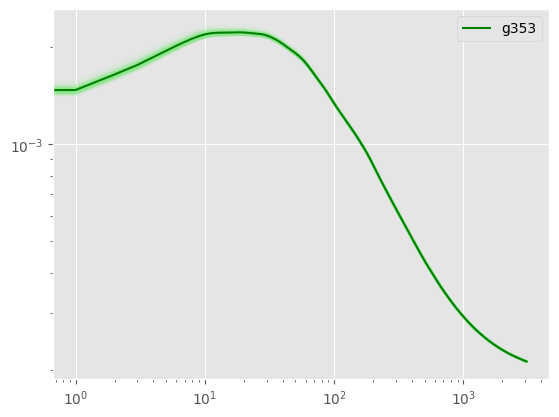

In [52]:
ells = np.arange(3071)

for i in range(0,1000,10):
    # plt.loglog(ells,
    #        theory['cgg'][i],
    #        c='lightblue',alpha=0.01)
    
    plt.loglog(ells,
            cgI_r[i][0],
            c='lightgreen',
            alpha=0.1)
    
# plt.loglog(ells,
#            theory['cgg'].mean(axis=0),
#            label='gg',c='b')

nulist = ['353','545','857']

for i in range(1): 
    plt.loglog(ells,
           cgI_r.mean(axis=0)[i],
           label=f'g{nulist[i]}',
           c='g')

plt.legend(loc='best')

In [3]:
import numpy as np
import pickle
from galCIB import SnuModel, CIBModel, PkBuilder, AnalysisModel

In [4]:
mag_alpha = 2.225
NSIDE = 1024
LMAX = 3 * NSIDE - 1
NSIMS = 1000
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

In [25]:
# define fiducial values for M21 model
# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
theta_hmalpha = np.array([0.7]) # Use Mead+2020 value 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = 10**(shotnoise_gCIB - 2) # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
#shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

# physical parameters of importance
theta_cen = np.array([3.28, 11.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.38, 10**11.14, 10**13., 0.59]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.52, 9.07, 0.7]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 
                      11.52,-0.02, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.38, 2.6, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [6]:
import pickle 

dndz_all = pickle.load(open("/Users/tkarim/research/galCIB/data/gal/dndz_extended.p", "rb"))
dndz = dndz_all['dndz']
zrange = dndz_all['zrange']

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_46587/4221559444.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/tkarim/research/galCIB/data/gal/dndz_extended.p'>
  dndz_all = pickle.load(open("/Users/tkarim/research/galCIB/data/gal/dndz_extended.p", "rb"))


In [7]:
## Setup CIB 
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters
fpath = "/Users/tkarim/research/galCIB"
cib_filters = load_my_filters(f"{fpath}/data/filters/",
                              nu_obs=nu_obs)

## Setup Survey 
from galCIB import Survey 
LMIN = 0
ells = np.arange(LMIN, LMAX)
nbins = 20
binned_ell_ledges = np.logspace(np.log10(LMIN), 
                                np.log10(LMAX),
                                nbins)


# Setup cosmology
from galCIB import Cosmology
cosmo = Cosmology(zrange, ks, Mh, 
                  colossus_cosmo_name='planck18',
                  use_little_h=False)

# Setup ELG HOD 
from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

# Setup Satellite Profile Model 
from galCIB import SatProfile
elg_sat_profile = SatProfile(cosmo, theta_prof,
                             profile_type='mixed')




/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_46587/1847475014.py:15: RuntimeWarning: divide by zero encountered in log10
  binned_ell_ledges = np.logspace(np.log10(LMIN),
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start
/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


In [8]:
# Setup SFR Model
from galCIB import SFRModel
# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)
sfr_model = SFRModel(name="M21", 
                     hod=hod_IR, 
                     fsub=0.134)

In [9]:
i = 0 
from galCIB import Survey 
elg_survey = Survey(z=zrange, 
                 pz=dndz[i],
                 mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE, 
                 binned_ell_ledges=binned_ell_ledges,
                 name="ELG-Planck")

# Compute window 
elg_survey.compute_windows(cosmo,True)

# Setup Snu Model 
# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", 
                        cosmo=cosmo,
                        survey=elg_survey,
                        nu_prime=np.array([353, 
                                            545, 
                                            857]))

In [10]:
# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                snu_model=snu_model_M21,
                hod_IR=hod_IR)

# Setup Pk Object
# M21 
pk_survey_M21 = PkBuilder(hod_model=elg_hod_model,
                            cib_model=cib_M21,
                            prof_model=elg_sat_profile
                    )

from galCIB import AnalysisModel
# Setup Analysis Model 
analysis = AnalysisModel(survey=elg_survey,
                            pk3d=pk_survey_M21)

In [29]:
cgg, tcgI, tcII = analysis.update_cl(theta_cen=theta_cen,
                        theta_sat=theta_sat,
                        theta_prof=theta_prof,
                        theta_sfr=theta_sfr_M21,
                        theta_snu=theta_snu,
                        theta_IR_hod=theta_IR,
                        theta_sn_gI=shotnoise_gCIB,
                        theta_sn_II=shotnoise_CIBCIB,
                        hmalpha=np.array([1]))

/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


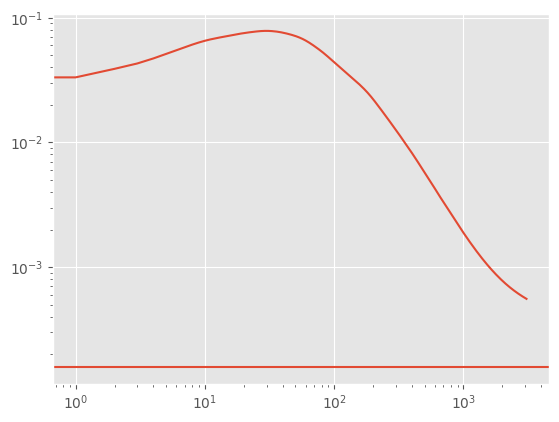

In [30]:
plt.loglog(tcgI[0])
plt.axhline(shotnoise_gCIB[0])

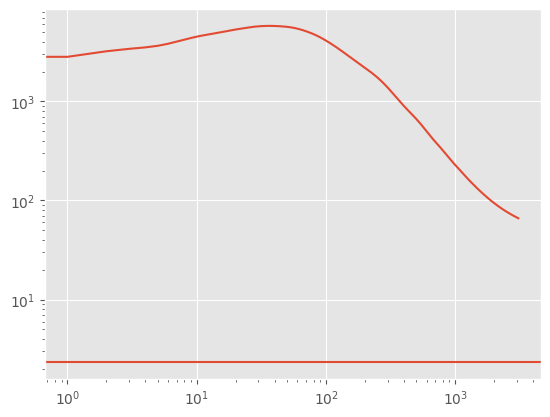

In [31]:
plt.loglog(tcII[0])
plt.axhline(shotnoise_CIBCIB[0])

In [32]:
import matplotlib.pyplot as plt 

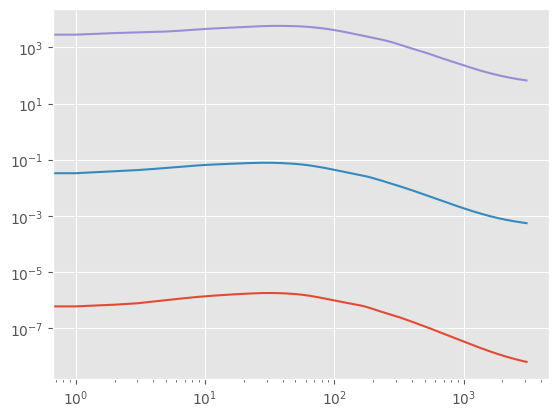

In [33]:
plt.loglog(cgg)
plt.loglog(tcgI[0])
plt.loglog(tcII[0])

# Issues: 
- ~~Calculate $k$ for given $\ell$ per $z$, and re sample $P(k)$.~~ 
- ~~Integrate over the same $\ell$-to-$k$ grid~~
- ~~SFR Model test~~
- ~~SFR Model registry setup~~
- $S_{\nu}$ Model test
    - M21
    - ~~Y23~~
- $S_{\nu}$ Model registry setup 
    - M21
    - ~~Y23~~
- ~~$S_{\nu}$ filter turn-on option and utils to convolve with Planck filter~~
- $\theta$ update method in `AnalysisModel`
- Write submodule on MCMC and setup `loglikelihood` method 
- Run MCMC with just $C_{\rm gg}$
- $P_{\rm CIB-CIB}$ and $P_{\rm g-CIB}$
- Refactor `pk.py`; compute.py to contain all the Pk functions? 
- Include color correction in `AnalysisModel`
- Include `Survey`-specific $\ell$ binning in `AnalysisModel`.